# Explore Input Data

Explore preprocessed covid data before we applying topic modelling.

## About data

- Number of Unique COVID articles: 547,835
- Range of date: 25/07/2002 - 31/05/2022
- Number of English articles after preprocessing: 470,382

In [24]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import warnings
import re
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [25]:
INPUT_PATH = '../data/preprocessed_data/'

## Load Data

In [26]:
covid_df = pd.read_csv(INPUT_PATH + "merged_covid_articles.tsv", sep='\t', encoding='utf-8')

In [27]:
covid_df.shape

(470382, 74)

In [22]:
covid_df.head()

,_id,abstract,URL,resource,member,score,created,update-policy,license,ISSN,container-title,issued,prefix,reference-count,indexed,author,DOI,is-referenced-by-count,published,published-print,alternative-id,subject,published-online,content-domain,reference,title,link,source,type,publisher,volume,references-count,issn-type,deposited,page,short-container-title,import-source,last-updated,issue,journal-issue,published-other,funder,assertion,posted,subtype,accepted,group-title,institution,editor,relation,original-title,subtitle,archive,article-number,event,update-to,clinical-trial-number,isbn-type,ISBN,edition-number,publisher-location,chair,degree,approved,translator,pubmed-abstract,content-created,description,review,standards-body,content-updated,short-title,part-number,language
0,10.1177/20503121211027778,<jats:sec><jats:title>Objective:</jats:title><...,http://dx.doi.org/10.1177/20503121211027778,{'primary': {'URL': 'http://journals.sagepub.c...,179.0,0,"{'date-parts': [[2021, 6, 30]], 'date-time': '...",http://dx.doi.org/10.1177/sage-journals-update...,"[{'start': {'date-parts': [[2021, 1, 1]], 'dat...","['2050-3121', '2050-3121']",['SAGE Open Medicine'],"{'date-parts': [[2021, 1]]}",10.1177,16,"{'date-parts': [[2022, 5, 26]], 'date-time': '...",[{'ORCID': 'http://orcid.org/0000-0003-0697-91...,10.1177/20503121211027778,3,"{'date-parts': [[2021, 1]]}","{'date-parts': [[2021, 1]]}",['10.1177/20503121211027778'],['General Medicine'],"{'date-parts': [[2021, 6, 30]]}","{'domain': ['journals.sagepub.com'], 'crossmar...","[{'key': 'bibr1-20503121211027778', 'doi-asser...",['COVID-19 and dysnatremia: A comparison betwe...,[{'URL': 'http://journals.sagepub.com/doi/pdf/...,Crossref,journal-article,SAGE Publications,9,16,"[{'value': '2050-3121', 'type': 'print'}, {'va...","{'date-parts': [[2021, 6, 30]], 'date-time': '...",205031212110277,['SAGE Open Medicine'],crossref_all_json.tar.gz,{'$date': '2022-06-12T11:41:05.722Z'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en
1,10.1093/ofid/ofaa439.692,<jats:title>Abstract</jats:title>\n ...,http://dx.doi.org/10.1093/ofid/ofaa439.692,{'primary': {'URL': 'https://academic.oup.com/...,286.0,0,"{'date-parts': [[2021, 1, 2]], 'date-time': '2...",NaN,"[{'start': {'date-parts': [[2021, 1, 2]], 'dat...",['2328-8957'],['Open Forum Infectious Diseases'],"{'date-parts': [[2020, 10, 1]]}",10.1093,0,"{'date-parts': [[2022, 4, 3]], 'date-time': '2...","[{'given': 'Minji', 'family': 'Kang', 'sequenc...",10.1093/ofid/ofaa439.692,0,"{'date-parts': [[2020, 10, 1]]}","{'date-parts': [[2020, 12, 31]]}",NaN,"['Infectious Diseases', 'Oncology']","{'date-parts': [[2020, 12, 31]]}","{'domain': [], 'crossmark-restriction': False}",NaN,['499. Infection with Coronavirus Disease 19 (...,[{'URL': 'http://academic.oup.com/ofid/article...,Crossref,journal-article,Oxford University Press (OUP),7,0,"[{'value': '2328-8957', 'type': 'electronic'}]","{'date-parts': [[2021, 1, 2]], 'date-time': '2...",S315-S315,NaN,crossref_all_json.tar.gz,{'$date': '2022-06-12T13:27:14.345Z'},Supplement_1,"{'issue': 'Supplement_1', 'published-print': {...","{'date-parts': [[2020, 10, 1]]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en
2,10.3390/vaccines9050490,"<jats:p>(1) Background: By April 2021, over 16...",http://dx.doi.org/10.3390/vaccines9050490,{'primary': {'URL': 'https://www.mdpi.com/2076...,1968.0,0,"{'date-parts': [[2021, 5, 12]], 'date-time': '...",NaN,"[{'start': {'date-parts': [[2021, 5, 11]], 'da...",['2076-393X'],['Vaccines'],"{'date-parts': [[2021, 5, 11]]}",10.3390,38,"{'date-parts': [[2022, 4, 1]], 'date-time': '2...","[{'given': 'Lu', 'family': 'Li', 'sequence': '...",10.3390/vaccines9050490,3,"{'date-parts': [[2021, 5, 11]]}",NaN,['vaccines9050490'],"['Pharmacology (medical)', 'Infectious Disease...","{'date-parts': [[2021, 5, 11]]}","{'domain': []

## Missing abstract

Find out how many articles missed abstract 

In [6]:
covid_df['abstract'] = covid_df['abstract'].astype(str)
covid_df['pubmed-abstract'] = covid_df['pubmed-abstract'].astype(str)

covid_df['abstract'] = covid_df['abstract'].apply(lambda x:x.replace('nan',''))
covid_df['pubmed-abstract'] = covid_df['pubmed-abstract'].apply(lambda x:x.replace('nan',''))

covid_df['merged_abstract'] = covid_df['abstract'] + covid_df['pubmed-abstract']

In [7]:
without_abstract = len(covid_df.loc[covid_df['merged_abstract'] == ''])
with_abstract = len(covid_df)-without_abstract
print("There are {} articles missing abstract ({}%)".format(without_abstract, round(without_abstract/len(covid_df)*100),1))
print("There are {} articles with abstract ({}%)".format(with_abstract, round(with_abstract/len(covid_df)*100), 1))

There are 222849 articles missing abstract (47%)
There are 247533 articles with abstract (53%)


## Article Timeframe

In [28]:
def date_formatting(date_str):
    date_str = date_str.replace("'", '"')
    date = json.loads(date_str)
    row_value = date['date-parts']
    year = row_value[0][0]
    month = row_value[0][1]
    day = row_value[0][2]
    return "{}/{}/{}".format(month, day, year)

In [29]:
# Timeframe of created date
sub_df = covid_df[['_id', 'created']]

sub_df['date'] = sub_df['created'].apply(lambda x: date_formatting(x))
sub_df['Year'] = pd.to_datetime(sub_df['date']).dt.to_period('Y')
sub_df['YearMonth'] = pd.to_datetime(sub_df['date']).dt.to_period('M')
sub_df['Date'] = pd.to_datetime(sub_df['date']).dt.to_period('D')
sub_df.sort_values(by='Date')

,_id,created,date,Year,YearMonth,Date
404947,10.1016/0734-9750(96)83056-4,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002,2002-07,2002-07-25
418719,10.1016/s0166-0934(98)00167-0,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002,2002-07,2002-07-25
418720,10.1016/s0168-1702(00)00209-4,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002,2002-07,2002-07-25
403243,10.1016/0014-5793(78)80935-1,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002,2002-07,2002-07-25
408181,10.1016/s0928-0197(98)00067-1,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002,2002-07,2002-07-25
...,...,...,...,...,...,...
285650,10.1109/edunine53672.2022.9782344,"{'date-parts': [[2022, 5, 31]], 'date-time': '...",5/31/2022,2022,2022-05,2022-05-31
222760,10.1109/edunine53672.2022.9782397,"{'date-parts': [[2022, 5, 31]], 'date-time': '...",5/31/2022,2022,2022-05,2022-05-31
222759,10.1016/j.arabjc.2022.104020,"{'date-parts': [[2022, 5, 31]], 'date-time': '...",5/31/2022,2022,2022-05,2022-05-31
285642,10.1016/j.indmarman.2022.05.011,"{'date-parts': [[2022, 5, 31]], 'date-time': '...",5/31/2022,2022,2022-05,2022-05-31


## Article Trend

In [30]:
count_df = sub_df[['date','YearMonth']].groupby('YearMonth').count().reset_index()
count_df.columns = ['YearMonth', 'Number of articles']
count_df.YearMonth = count_df.YearMonth.astype(str)

In [32]:
count_df.to_csv("../Data/figures/articles_by_month.csv", index=False)

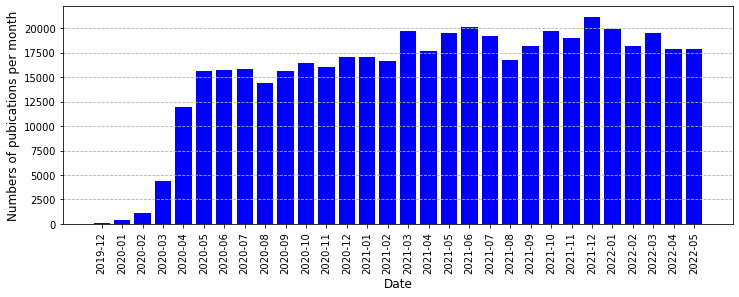

In [11]:
# Print number of pubications per month

count_df = sub_df[['date','YearMonth']].groupby('YearMonth').count().reset_index()
count_df.columns = ['YearMonth', 'Number of articles']
count_df.YearMonth = count_df.YearMonth.astype(str)

months = list(count_df['YearMonth'].iloc[-30:])
values = list(count_df['Number of articles'].iloc[-30:]) 
fig = plt.figure(figsize = (12, 4))
# creating the bar plot
plt.bar(months, values, color='blue')
plt.xticks(rotation=90) 
plt.xlabel("Date", fontsize=12)
plt.ylabel("Numbers of pubications per month", fontsize=12)
plt.grid(True, axis='y', linestyle='--')

plt.savefig('../img/article_distribution(Month).pdf', format='pdf', bbox_inches='tight') 

plt.show()

Text(0.5, 0, 'Year')

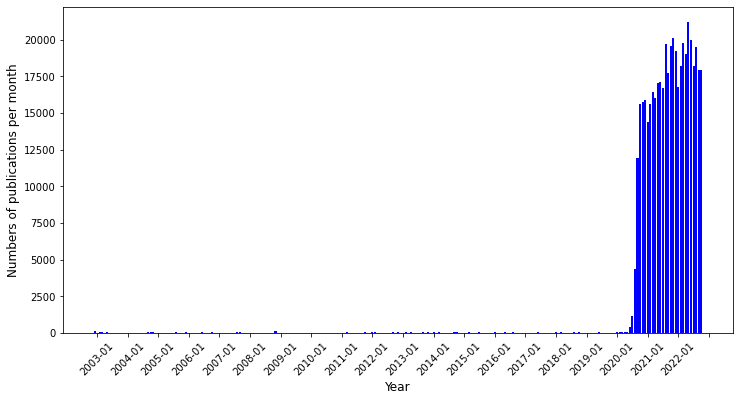

In [13]:
#plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

x_value = list(count_df['YearMonth'])
y_value = list(count_df['Number of articles']) 
x_pos = [i for i, _ in enumerate(x_value)]

# bar plot 
ax1.bar(x_pos, y_value, color='blue')
ax1.set_ylabel("Numbers of publications per month", fontsize=12)

# xticks ----------------------------------------------""\
n = 12
thick_list = [] 
for x in range(6, len(x_value), n):
    thick_list.append(x_value[x])

new_x_pos = list(range(1, len(x_value)+14, n))     
plt.xticks(new_x_pos, thick_list, rotation=45) 
ax1.set_xlabel('Year', fontsize=12)

## Publishers

In [45]:
print(covid_df['publisher'].isnull().sum())
covid_df['publisher'].describe()

213


count          470169
unique           9054
top       Elsevier BV
freq            67611
Name: publisher, dtype: object

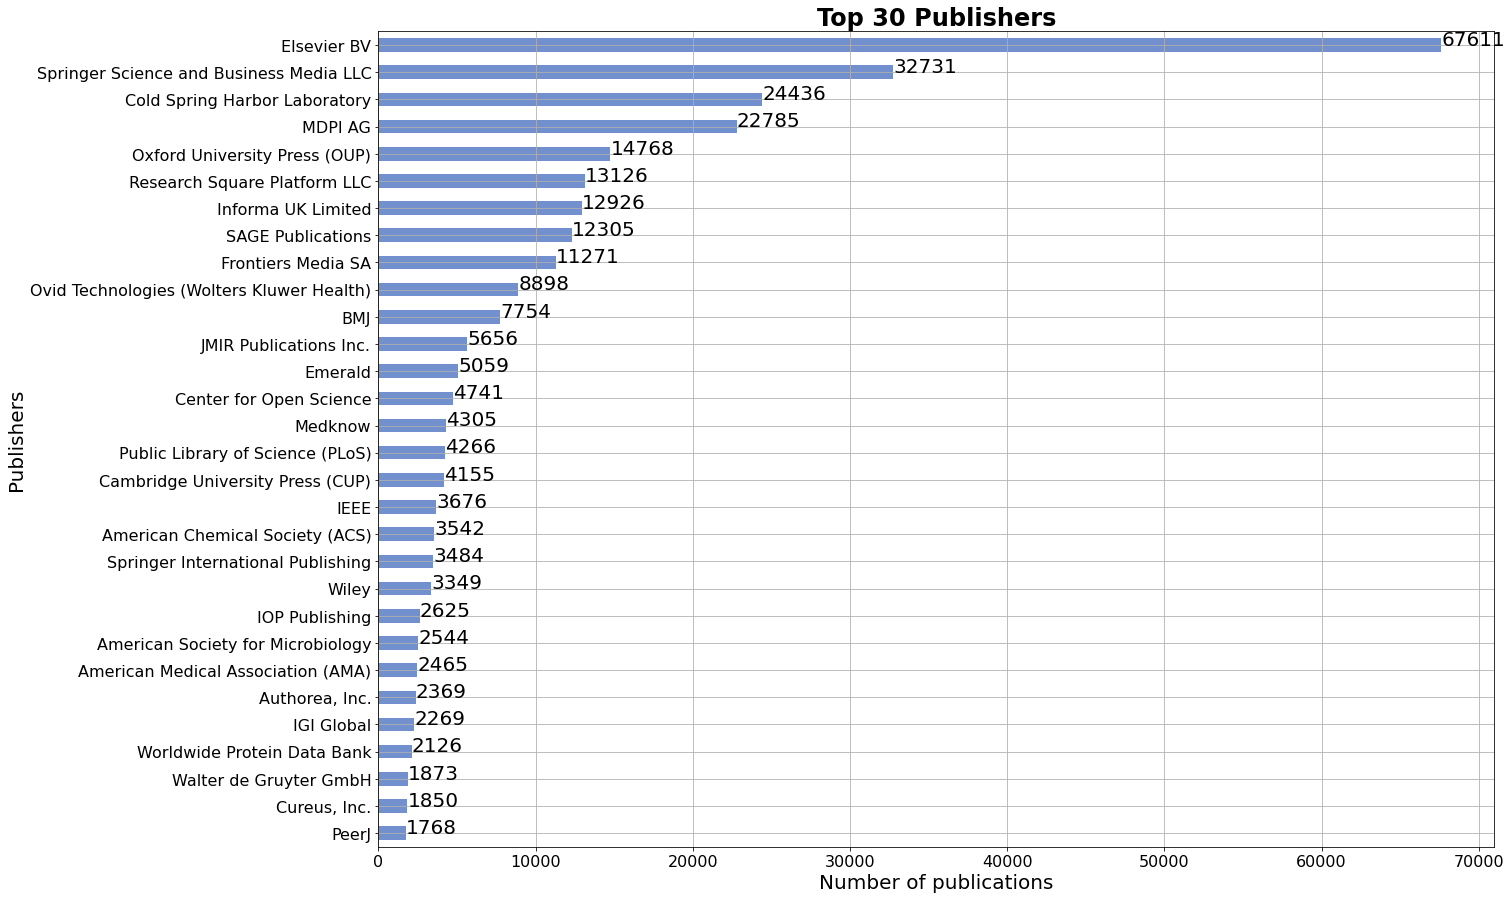

In [46]:
top_n = 30

ax = covid_df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).head(top_n).plot(
    kind='barh', fontsize=16, color='#728FCE',figsize = (20,15))

# top shows biggest value
ax.invert_yaxis() 

# for showing values on bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=20)
plt.xlabel('Number of publications', size = 20)
plt.ylabel('Publishers', size = 20)
plt.title('Top {} Publishers'.format(top_n), size = 24, weight='bold')
plt.grid(True)

plt.savefig('../img/Top_{}_publishers_barchart.pdf'.format(top_n), format='pdf', bbox_inches='tight')  

## Subjects

In [33]:
num_missing= covid_df['subject'].isnull().sum()

print("{} of pubs missing subject ({}%)".format(num_missing, round(num_missing/len(covid_df)*100), 1))
covid_df['subject'].describe()

185817 of pubs missing subject (40%)


count                   284565
unique                    5620
top       ['General Medicine']
freq                     37911
Name: subject, dtype: object

In [34]:
# find subject usuage

subjects_dict = {}
for index, row in covid_df.iterrows():
    if len(str(row['subject'])) > 3:
        subjects = eval(row['subject'])
        for s in subjects:
            if s in subjects_dict.keys():
                subjects_dict[s] += 1
            else:
                subjects_dict[s] = 1
        
sorted_sub_dict = dict( sorted(subjects_dict.items(), key=operator.itemgetter(1),reverse=True))
sub_df = pd.DataFrame()
sub_df['Subjects'] = sorted_sub_dict.keys()
sub_df['Number of publications'] = sorted_sub_dict.values()

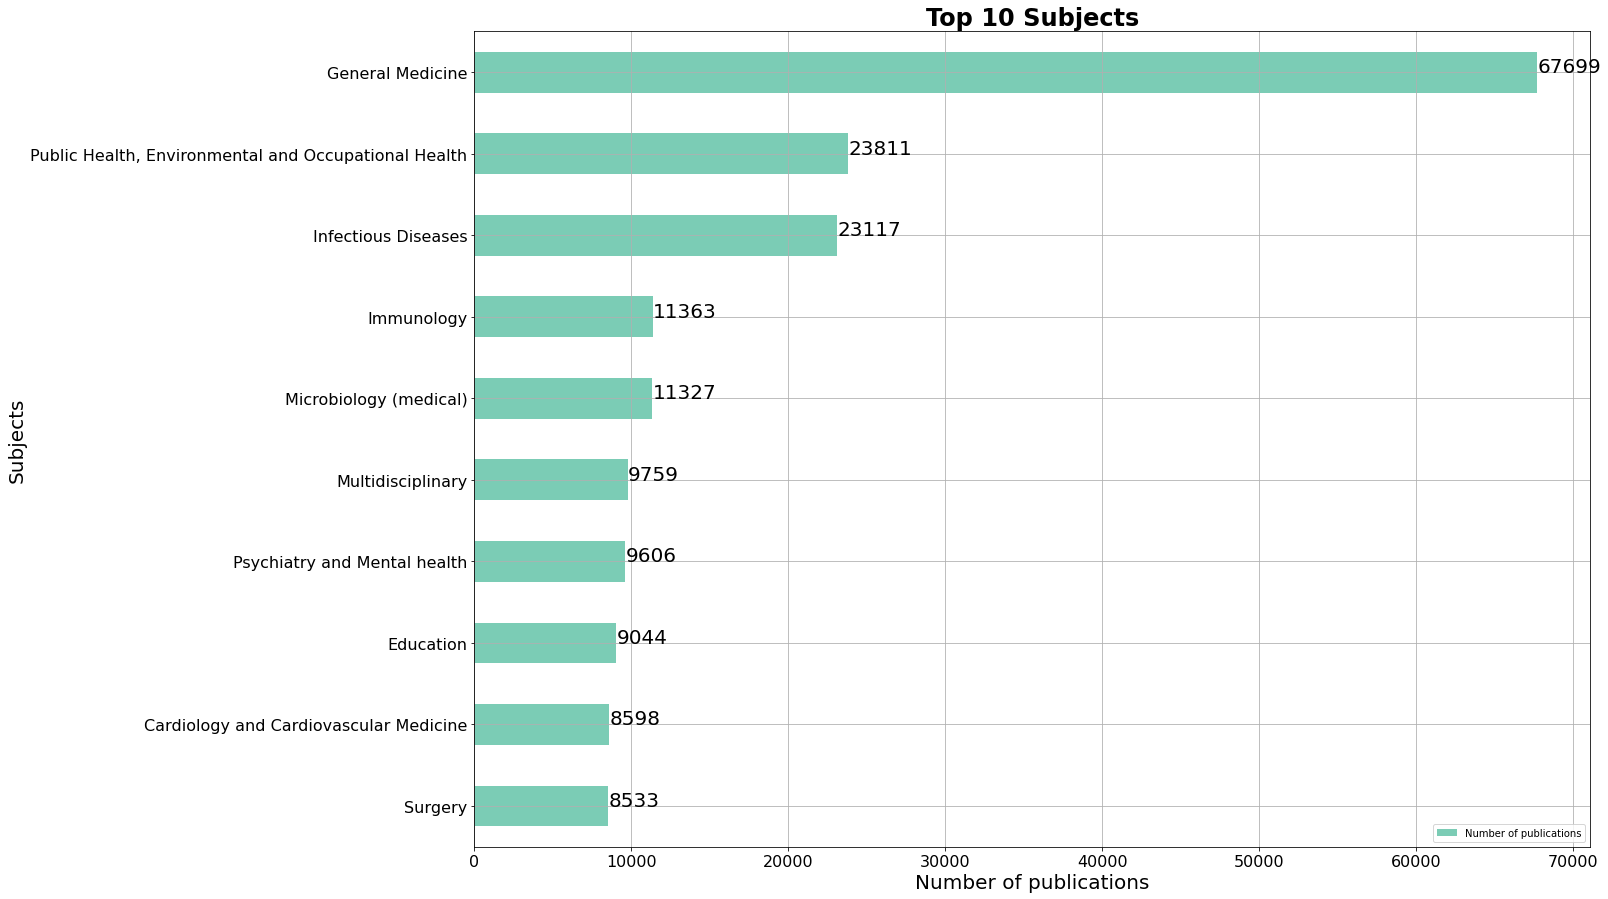

In [35]:
sub_df.index = sub_df['Subjects']
ax = sub_df.head(top_n).plot(
    kind='barh', fontsize=16, color='#7BCCB5',figsize = (20,15))
# top shows biggest value
ax.invert_yaxis() 
# ax.bar_label(ax.containers[0]) 
# for showing values on bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=20)
plt.xlabel('Number of publications', size = 20)
plt.ylabel('Subjects', size = 20)
plt.title('Top {} Subjects'.format(top_n), size = 24, weight='bold')
plt.grid(True)

plt.savefig('../img/Top_{}_subjects_barchart.pdf'.format(top_n), format='pdf', bbox_inches='tight') 

## Container Titles

In [36]:
not_null_container_df = covid_df.loc[covid_df['container-title'] != 'nan']
print(not_null_container_df.shape, covid_df.shape)

(470382, 74) (470382, 74)


In [37]:
num_missing= not_null_container_df['container-title'].isnull().sum()

not_null_container_df = covid_df.loc[covid_df['container-title'] != 'nan']
covid_df['container-title'].describe()

count                          404531
unique                          39673
top       ['SSRN Electronic Journal']
freq                            10072
Name: container-title, dtype: object

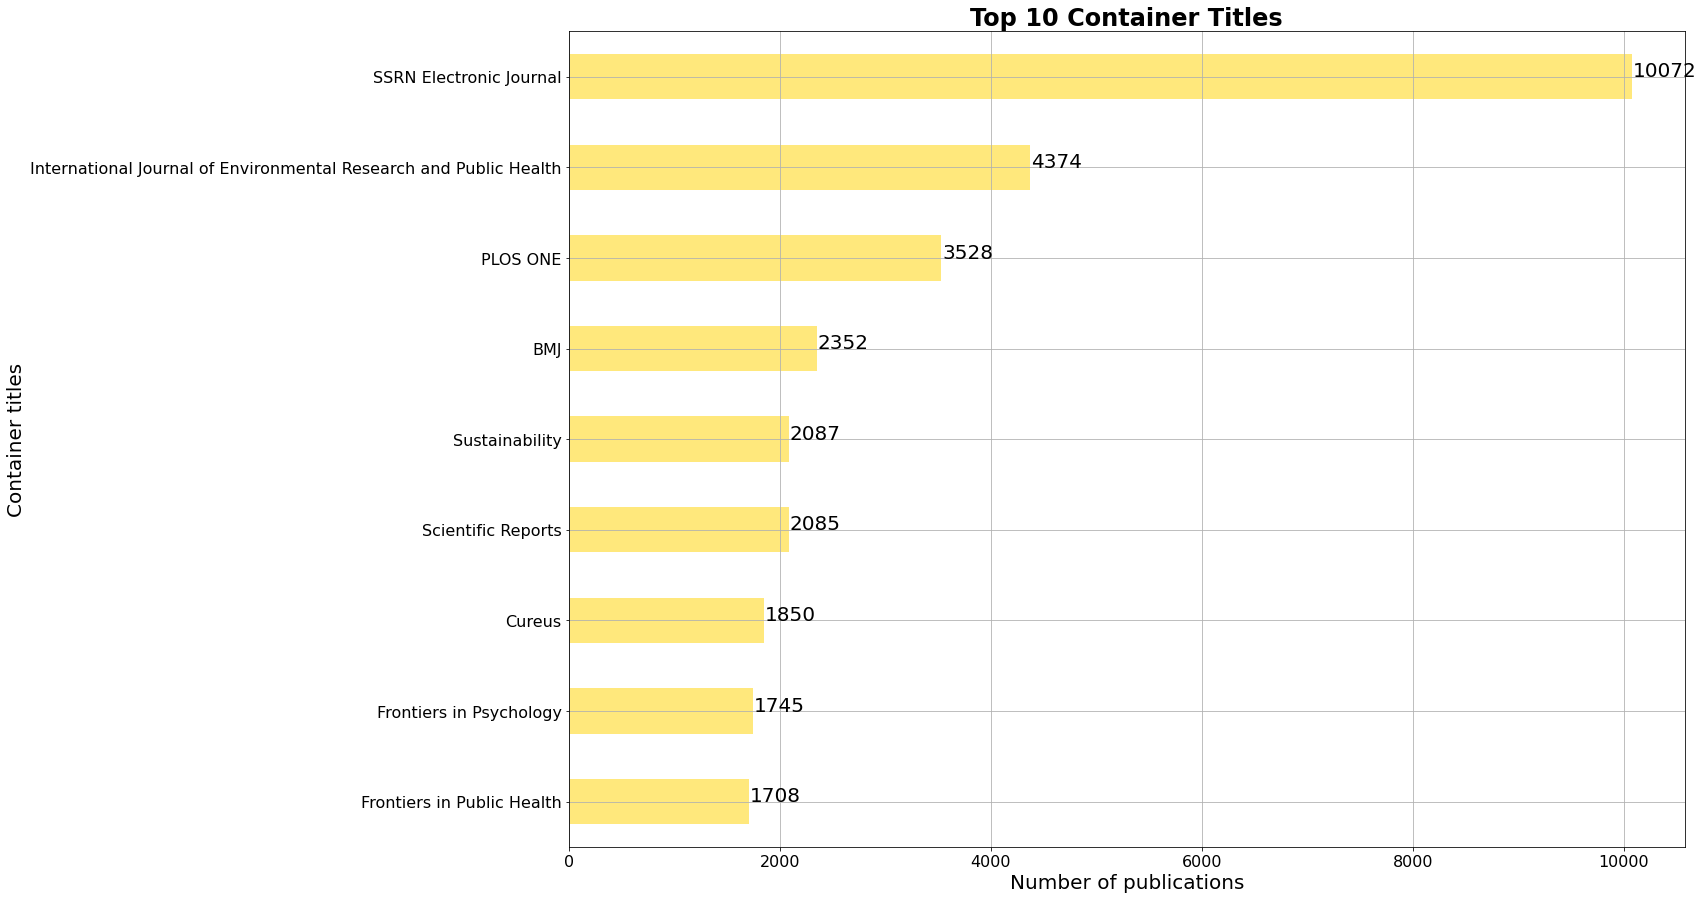

In [38]:
covid_df['container-title'] = covid_df['container-title'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r'', str(x)))

ax = covid_df.groupby('container-title')['_id'].nunique().sort_values(ascending=False)[1:top_n].plot(
    kind='barh', fontsize=16, color='#FFE87C',figsize = (20,15))


# top shows biggest value
ax.invert_yaxis() 
# for showing values on bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=20)
plt.xlabel('Number of publications', size = 20)
plt.ylabel('Container titles', size = 20)
plt.title('Top {} Container Titles'.format(top_n), size = 24, weight='bold')
plt.grid(True)

plt.savefig('../img/Top_{}_container_titles_barchart.pdf'.format(top_n), format='pdf', bbox_inches='tight') 

## Funders

In [39]:
covid_df['funder'] = covid_df['funder'].astype(str)
num_missing = len(covid_df.loc[covid_df['funder'] == 'nan'])

print("{} of pubs missing funder ({}%)".format(num_missing, round(num_missing/len(covid_df)*100), 1))
covid_df['funder'].describe()

412456 of pubs missing funder (88%)


count     470382
unique     48276
top          nan
freq      412456
Name: funder, dtype: object

In [40]:
# find subject usuage

funder_dict = {}
for index, row in covid_df.iterrows():
    if len(str(row['funder'])) > 3:
        funders = eval(row['funder'])
        for f in funders:
            try:
                funder = f['name']
                if funder in funder_dict.keys():
                    funder_dict[funder] += 1
                else:
                    funder_dict[funder] = 1
            except:
                continue
        
sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
funder_df = pd.DataFrame()
funder_df['Funders'] = sorted_funder_dict.keys()
funder_df['Number of publications'] = sorted_funder_dict.values()

## Subplots

In [41]:
publisher_df = covid_df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
publisher_df.columns = ['publisher','Number of publications']

In [42]:
container_df = covid_df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
container_df.columns = ['container_title','Number of publications']
container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
container_df

,container_title,Number of publications
0,nan,65851
1,SSRN Electronic Journal,10072
2,International Journal of Environmental Researc...,4374
3,PLOS ONE,3528
4,BMJ,2352
...,...,...
39341,Dzce niversitesi Salk Bilimleri Enstits Dergisi,1
39342,REESME 13 Revista Espaola de Enfermera de Salu...,1
39343,REICE Revista Electrnica de Investigacin en Ci...,1
39344,Korean Financial Law Association,1


In [43]:
def draw_subplots(top_n, df1, df2, df3, df4):
    fig, axs = plt.subplots(4,1,figsize=(12,16))
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['Number of publications'].iloc[:top_n])     
    axs[0].barh(x, y, color='#728FCE')
    # top shows biggest value
    axs[0].invert_yaxis() 
    # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[0].title.set_text("Top publishers")
    
    
    x = list(df2['Subjects'].iloc[:top_n])
    y = list(df2['Number of publications'].iloc[:top_n])     
    axs[1].barh(x, y, color='#7BCCB5')
    # top shows biggest value
    axs[1].invert_yaxis() 
    # for showing values on bar
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[1].title.set_text("Top subjects")
    
    x = list(df3['container_title'].iloc[1:top_n])
    y = list(df3['Number of publications'].iloc[1:top_n])     
    axs[2].barh(x, y, color='#FFE87C')
    # top shows biggest value
    axs[2].invert_yaxis() 
    # for showing values on bar
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[2].title.set_text("Top journals/conferences")
    
    x = list(df4['Funders'].iloc[:top_n])
    y = list(df4['Number of publications'].iloc[:top_n])     
    axs[3].barh(x, y)
    # top shows biggest value
    axs[3].invert_yaxis() 
    # for showing values on bar
    for p in axs[3].patches:
        axs[3].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[3].title.set_text("Top funders")
    
    plt.savefig('../img/top-{}-articles-metadata.jpeg'.format(top_n), doi='400', bbox_inches='tight')     
    

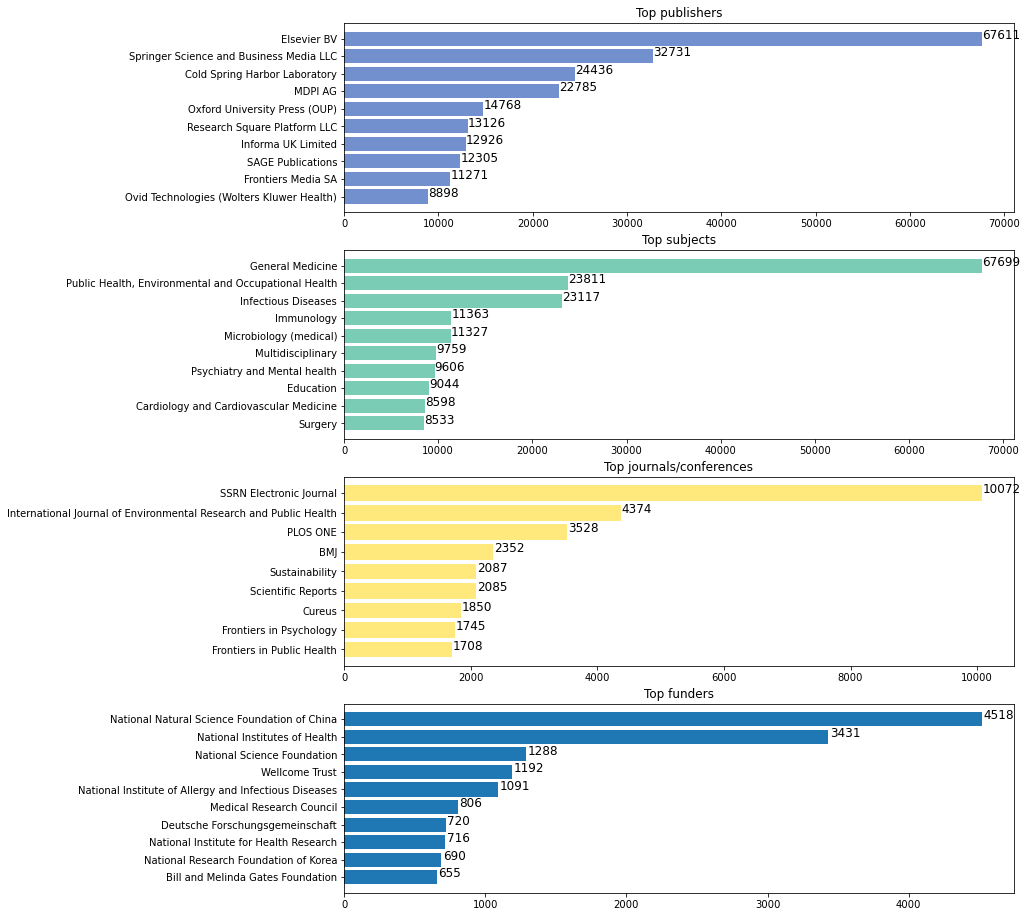

In [44]:
top_n = 10
draw_subplots(top_n, publisher_df, sub_df, container_df, funder_df)

In [46]:
publisher_df.to_csv("../Data/figures/top_publisher.csv", index=False)
sub_df.to_csv("../Data/figures/top_subject.csv", index=False)
container_df.to_csv("../Data/figures/top_container.csv", index=False)
funder_df.to_csv("../Data/figures/top_funder.csv", index=False)